<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/Bayes_PiecewiseLinModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Piecewise Linear Models

The main assumption of linear models is limitting in that there may be no fitting global trend in data, but different regions have their own local behavior. For example, when [predicting blood donation](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center) one finds that 
while in general the chances for a next donation increase with the blood volume donated already, very high values indicate regular donors who are "extra"  likely to spend.

Such situations are perfect case for piecewise linear models. The "knots", values which breake local trends, can be found by the exploratory analysis or, more systematically, by fitting a **bayesian model with thresholds being standalone parameters**.


In [ ]:
# download data
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data -o transfusion.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12843  100 12843    0     0  23608      0 --:--:-- --:--:-- --:--:-- 23608


In [ ]:
# install dependencies for plotting traces
!pip install arviz
!pip uninstall pymc3
!pip install pymc3>=3.8

Uninstalling pymc3-3.11.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pymc3-3.11.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pymc3/*
Proceed (y/n)? y
  Successfully uninstalled pymc3-3.11.2


## Exploratory Analysis

By looking into the data we see that the impact of the blood volume spent may depend on the value regime.

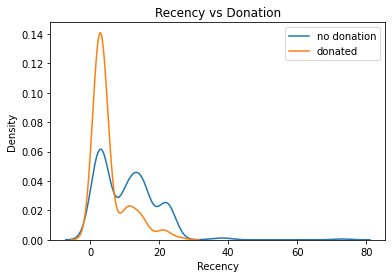

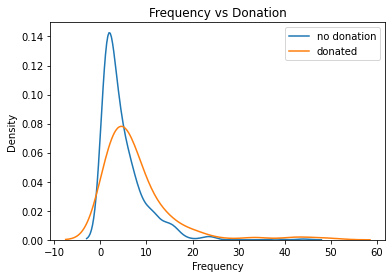

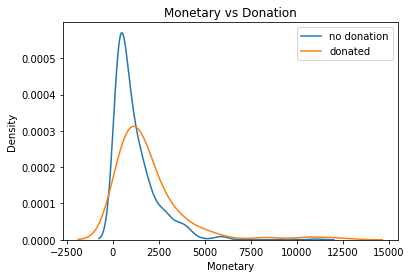

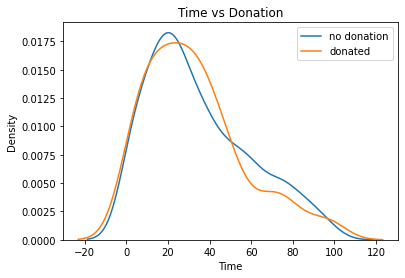

In [ ]:
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_csv('transfusion.data')
assert df.isna().any(0).sum() == 0
df.head()
df.columns = ['Recency','Frequency','Monetary','Time','Donated']

X,y = df[df.columns[:-1]],df[df.columns[-1]]

for c in X.columns:
  sns.kdeplot(X[y==0][c],label='no donation')
  sns.kdeplot(X[y==1][c],label='donated')
  plt.title('%s vs Donation'%c)
  plt.legend()
  plt.show()

## Bayesian Model

The bayesian model below finds the threshold for two different trends on the  volume spent ("Monetary"). Note that the data below are normalized.

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, w_up, w]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08fdc8e650>,
      dtype=object)

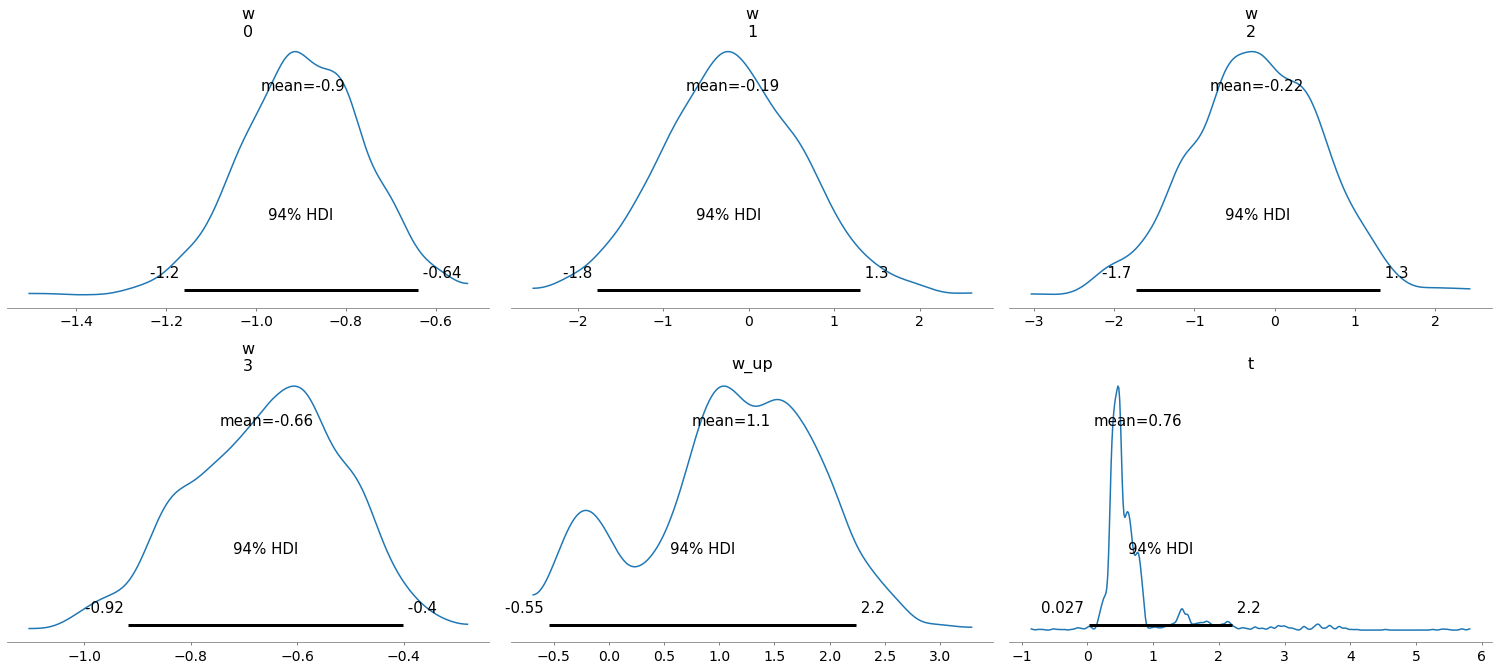

In [ ]:
import pymc3 as pm

base_cols = ['Recency','Frequency','Monetary','Time']
X_t = X[base_cols].values
X_t = X_t/X_t.std(0)
X_t.shape
y_t = y.values

with pm.Model() as bayes_model:
  w = pm.Normal('w',mu=0,sigma=1.0,shape=(X_t.shape[1],))
  lin_pred = pm.Deterministic('lin_pred',pm.math.dot(X_t,w))
  w_up = pm.Normal('w_up',mu=0,sigma=1.0)
  threshold = pm.Normal('t',mu=2.0,sigma=1)
  lin_pred = lin_pred+(X_t[:,-2]>threshold)*X_t[:,-2]*w_up

  prob_pred = pm.invlogit(lin_pred)
  logp = pm.Bernoulli(name='logit', p=prob_pred, observed=y_t)

with bayes_model:
  trace = pm.sample(tune=2000,
                         draws=500,
                         chains=4,
                         init = 'adapt_diag',
                         cores=4)
  
pm.plot_posterior(trace,var_names=['w','w_up','t'])

## Piecewise Model

Introducing a separate slope for the regime of "high" blood volume improves the model as seen by BIC and cross-validated balanced accuracy.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import bic

# baseline model
formula = 'Donated~Recency+Frequency+Monetary+Time'
model = smf.glm(formula=formula,data=df,family=sm.families.Binomial())
model = model.fit()
print(model.summary().tables[-1])
print('BIC=%s'%bic(model.llf,model.nobs,model.df_model))

# improved model
formula = 'Donated~Recency+Frequency+Monetary:I(Monetary>2000)+Time'
model = smf.glm(formula=formula,data=df,family=sm.families.Binomial())
model = model.fit()
print(model.summary().tables[-1])
print('BIC=%s'%bic(model.llf,model.nobs,model.df_model))

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4495      0.180     -2.493      0.013      -0.803      -0.096
Recency       -0.0986      0.017     -5.693      0.000      -0.133      -0.065
Frequency   2.166e-06   4.11e-07      5.274      0.000    1.36e-06    2.97e-06
Monetary       0.0005      0.000      5.274      0.000       0.000       0.001
Time          -0.0231      0.006     -3.872      0.000      -0.035      -0.011
BIC=727.7190055572008
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.9161      0.219     -4.190      0.000      -1.345      -0.488
Recency                               -0.0973      0.018     -5.487      0.000      -0.132      -0.063
Frequency    

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score,make_scorer
from sklearn.model_selection import StratifiedKFold,cross_validate

## baseline model
np.random.seed(1234)
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=np.random.RandomState(1234))
model = LogisticRegression()
base_cols = ['Recency','Frequency','Monetary','Time']
outs = cross_validate(model,X[base_cols],y,scoring=make_scorer(balanced_accuracy_score),cv=cv)['test_score']
print(outs.mean(),outs.std())

## optimized model
X['High Monetary'] = (X['Monetary']>1000)*X['Monetary']

outs = cross_validate(model,X,y,scoring=make_scorer(balanced_accuracy_score),cv=cv)['test_score']
print(outs.mean(),outs.std())

0.5591847265221878 0.037280831695449865
0.5796525627794977 0.044174035288943383
